In [115]:
import pandas as pd
import plotly.graph_objects as go

from plotly.subplots import make_subplots

import numpy as np

import statsmodels.api as sm

In [140]:
results_regiao = pd.read_csv('./results/backtracking_region.csv', index_col=0)
results_celula = pd.read_csv('./results/backtracking_celula.csv', index_col=0)

In [141]:
teste_podas = {
    'assign_from_singletons': pd.read_csv('./results/backtracking_region_sem_singletons.csv', index_col=0),
    'hidden_single': pd.read_csv('./results/backtracking_region_sem_hidden_single.csv', index_col=0),
    'naked_pairs': pd.read_csv('./results/backtracking_region_sem_naked_pairs.csv', index_col=0),
    'hidden_pairs': pd.read_csv('./results/backtracking_region_sem_hidden_pairs.csv', index_col=0),
    'naked_triples': pd.read_csv('./results/backtracking_region_sem_naked_triples.csv', index_col=0),
    'hidden_triples': pd.read_csv('./results/backtracking_region_sem_hidden_triples.csv', index_col=0),
}

# Resultados por regiao

In [142]:
results_regiao['blanks'] = results_regiao['size'] - results_regiao['dicas']
results_celula['blanks'] = results_celula['size'] - results_celula['dicas']

In [143]:
results_regiao['tabuleiro'] = ['15x10' if t == '15x10n=6' else t for t in results_regiao['tabuleiro']]
results_celula['tabuleiro'] = ['15x10' if t == '15x10n=6' else t for t in results_celula['tabuleiro']]

In [144]:
regras = ['assign_from_singletons','hidden_single', 'naked_pairs', 'hidden_pairs', 'naked_triples','hidden_triples']
tabuleiros = ['6x6', '8x8', '15x10']

In [145]:
def remove_outliers(s: pd.Series, factor: float = 1.5) -> pd.Series:
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return s[(s >= lower) & (s <= upper)]


In [146]:
def factorial(n):
    f = 1
    while n > 1:
        f *= n
        n -= 1
    return f

def total_tree_size(R,C,N, method='region'):
    if method == 'region':
        size = 0
        N_fat = factorial(N)
        for r in range(1, R+1):
            size += r
        size = size*N_fat
    else:
        size = 1
        for c in range(1, C+1):
            size += N**c
    return size


def equivalent_level(R, C, N): # em qual nível da árvore de célula as quantidades de nós se cruzam?
    level = 0
    for c in range(1, C+1):
        reg_size = total_tree_size(R,C,N, method='region')
        cell_size = total_tree_size(R,c,N, method='cell')
        if cell_size >= reg_size:
            level = c
            break
    if level == 0:
        level = -1
    return level


equivalent_level(
    R = 6,
    C = 6*6,
    N = 6,
    # method='cell'
)

6

## Nós

In [147]:
results_regiao['nos_visitados'] = results_regiao['nos_visitados'] + results_regiao['numero_regioes']
results_celula['nos_visitados'] = results_celula['nos_visitados'] + results_celula['size']


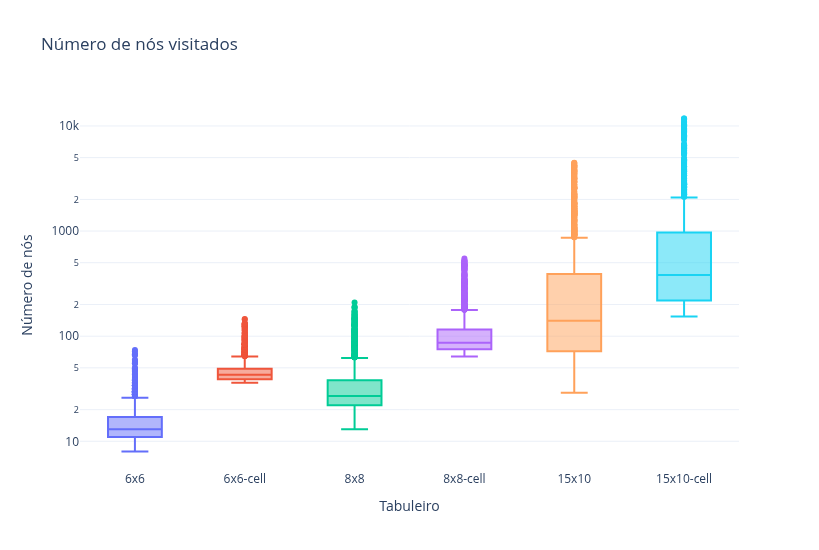

In [137]:
fig = go.Figure()

for tab in tabuleiros:
    r = results_regiao[results_regiao['tabuleiro'] == tab]
    series = remove_outliers(r['nos_visitados'], factor=10)
    box = go.Box(
        y = series,
        x = [tab for _ in series.index],
        name=tab
    )
    fig.add_trace(box)
    r = results_celula[results_celula['tabuleiro'] == tab]
    series = remove_outliers(r['nos_visitados'], factor=10)

    box = go.Box(
        y = series,
        x = [tab+'-cell' for _ in series.index],
        name=tab
    )
    fig.add_trace(box)


        
fig.update_yaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Número de nós visitados',
    xaxis_title='Tabuleiro',
    yaxis_title='Número de nós',
    height=550, width=600,
    showlegend=False
)


fig.show()

In [138]:
r.columns

Index(['id', 'tabuleiro', 'size', 'numero_regioes', 'tamanho_medio_regiao',
       'dificuldade', 'dicas', 'tempo', 'nos_visitados', 'profundidade_maxima',
       'total_podas', 'backtracks', 'resolvido', 'assign_from_singletons',
       'hidden_single', 'naked_pairs', 'hidden_pairs', 'naked_triples',
       'hidden_triples', 'blanks'],
      dtype='object')

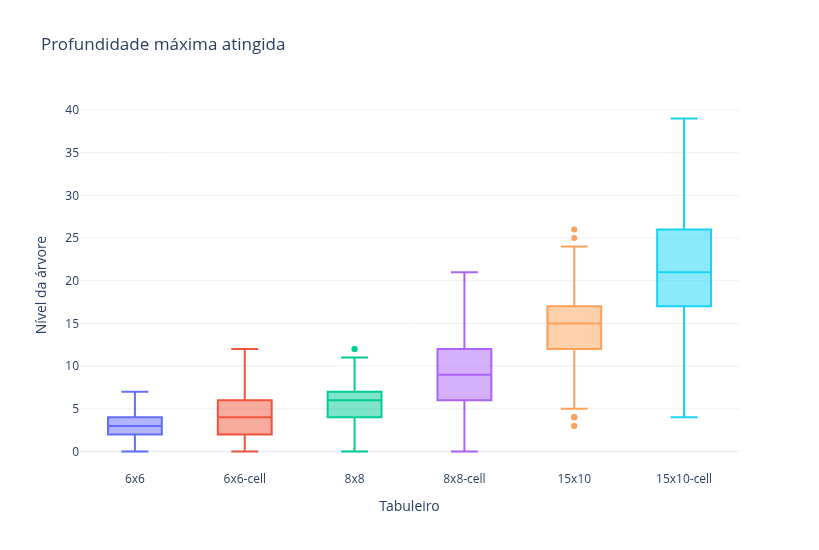

In [148]:
fig = go.Figure()

for tab in tabuleiros:
    r = results_regiao[results_regiao['tabuleiro'] == tab]
    # series = remove_outliers(r['profundidade_maxima'], factor=5)
    series = r['profundidade_maxima']
    box = go.Box(
        y = series,
        x = [tab for _ in series.index],
        name=tab
    )
    fig.add_trace(box)
    r = results_celula[results_celula['tabuleiro'] == tab]
    series = remove_outliers(r['profundidade_maxima'])

    box = go.Box(
        y = series,
        x = [tab+'-cell' for _ in series.index],
        name=tab
    )
    fig.add_trace(box)


        
# fig.update_yaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Profundidade máxima atingida',
    xaxis_title='Tabuleiro',
    yaxis_title='Nível da árvore',
    height=550, width=600,
    showlegend=False
)


fig.show()

## Regras

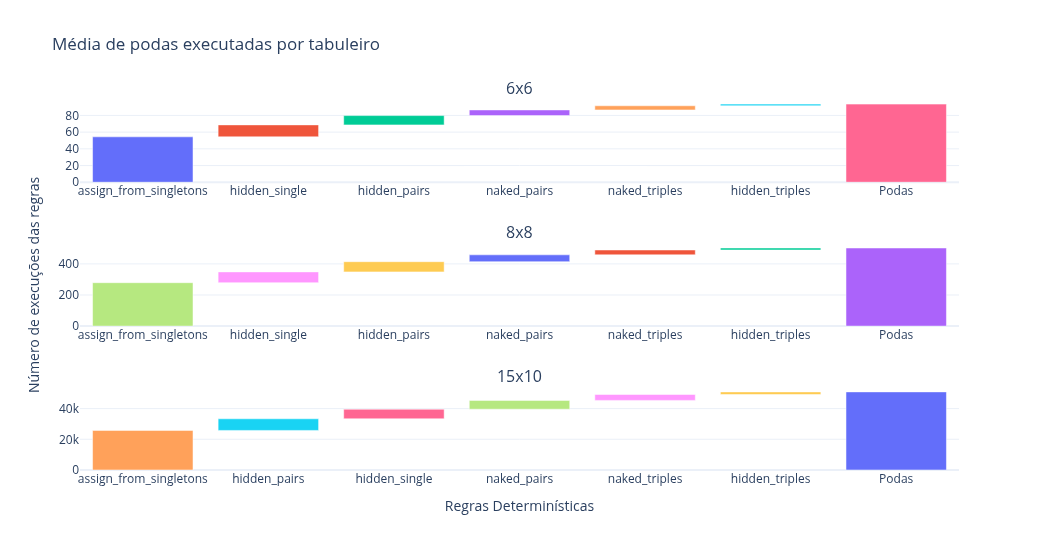

In [92]:
rows,cols=3,1
fig = make_subplots(rows=rows, cols=cols, subplot_titles=tabuleiros, shared_xaxes=False)

i,j=1,1
for tab in tabuleiros:
    r = results_regiao[results_regiao['tabuleiro'] == tab]
    if r.empty:
        continue
    podas_avg = r['total_podas'].mean()
    regras_avg = r[regras].mean()
    regras_avg = regras_avg / regras_avg.sum()
    regras_avg = regras_avg*podas_avg
    regras_avg.sort_values(ascending=False, inplace=True)
    base = 0
    for reg in regras_avg.index:
        b = go.Bar(
            y=[regras_avg[reg]],
            x=[reg],
            showlegend=False,
            name=reg,
            base=base
        )
        fig.add_trace(b, row=i, col=j)
        base += float(regras_avg[reg])
    b = go.Bar(
        y=[podas_avg],
        x=['Podas'],
        showlegend=False,
        name='Podas'
    )
    fig.add_trace(b, row=i, col=j)    

    j+=1
    if j > cols:
        j = 1
        i += 1
        
# fig.update_yaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Média de podas executadas por tabuleiro',
    xaxis3_title='Regras Determinísticas',
    yaxis2_title='Número de execuções das regras',
    height=550
)


fig.show()

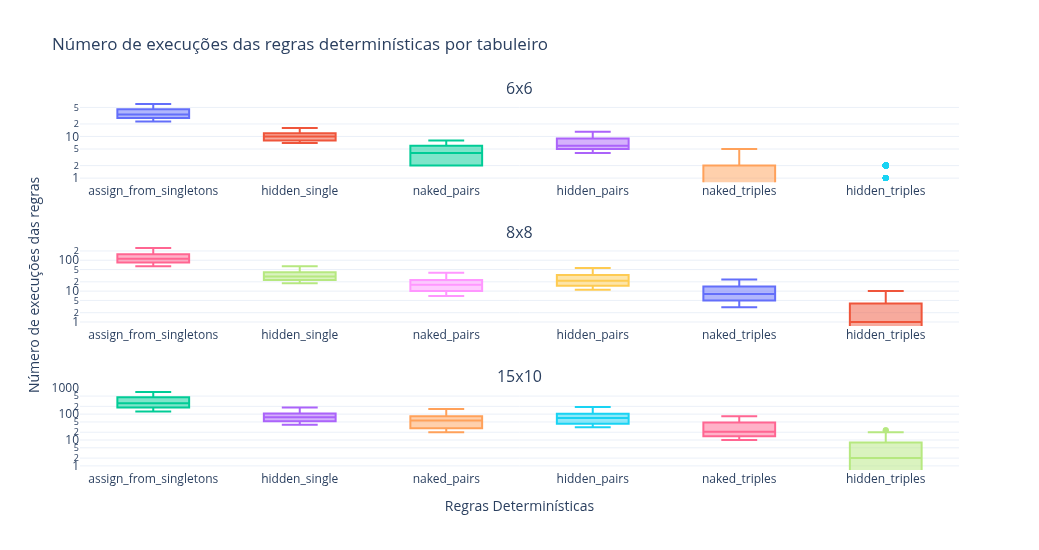

In [8]:
rows,cols=3,1
fig = make_subplots(rows=rows, cols=cols, subplot_titles=tabuleiros, shared_xaxes=False)

i,j=1,1
for tab in tabuleiros:
    r = results_regiao[results_regiao['tabuleiro'] == tab]
    if r.empty:
        continue
    # r = r[r['backtracks'] > 0]
    for reg in regras:
        series = remove_outliers(r[reg], 0)
        b = go.Box(
            y=series,
            x=[reg for _ in series.index],
            showlegend=False,
            name=reg
        )
        fig.add_trace(b, row=i, col=j)
    j+=1
    if j > cols:
        j = 1
        i += 1
        
fig.update_yaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Número de execuções das regras determinísticas por tabuleiro',
    xaxis3_title='Regras Determinísticas',
    yaxis2_title='Número de execuções das regras',
    height=550
)


fig.show()

In [18]:
from scipy.stats import wilcoxon

In [35]:
wilcoxon_results = {}
for tab in tabuleiros:
    r = results_regiao[results_regiao['tabuleiro'] == tab]
    wilcoxon_df = pd.DataFrame(columns=regras, index=regras)
    for i in range(len(regras)):
        regra1 = regras[i]
        for j in range(i+1, len(regras)):
            regra2 = regras[j]
            pvalue = wilcoxon(r[regra1], r[regra2]).pvalue
            wilcoxon_df.loc[regra1, regra2] = pvalue
    wilcoxon_results[tab] = wilcoxon_df

In [38]:
wilcoxon_results['15x10']

assign_from_singletons hidden_single naked_pairs  \
assign_from_singletons                    NaN           0.0         0.0   
hidden_single                             NaN           NaN         0.0   
naked_pairs                               NaN           NaN         NaN   
hidden_pairs                              NaN           NaN         NaN   
naked_triples                             NaN           NaN         NaN   
hidden_triples                            NaN           NaN         NaN   

                       hidden_pairs naked_triples hidden_triples  
assign_from_singletons          0.0           0.0            0.0  
hidden_single              0.079741           0.0            0.0  
naked_pairs                     0.0           0.0            0.0  
hidden_pairs                    NaN           0.0            0.0  
naked_triples                   NaN           NaN            0.0  
hidden_triples                  NaN           NaN            NaN

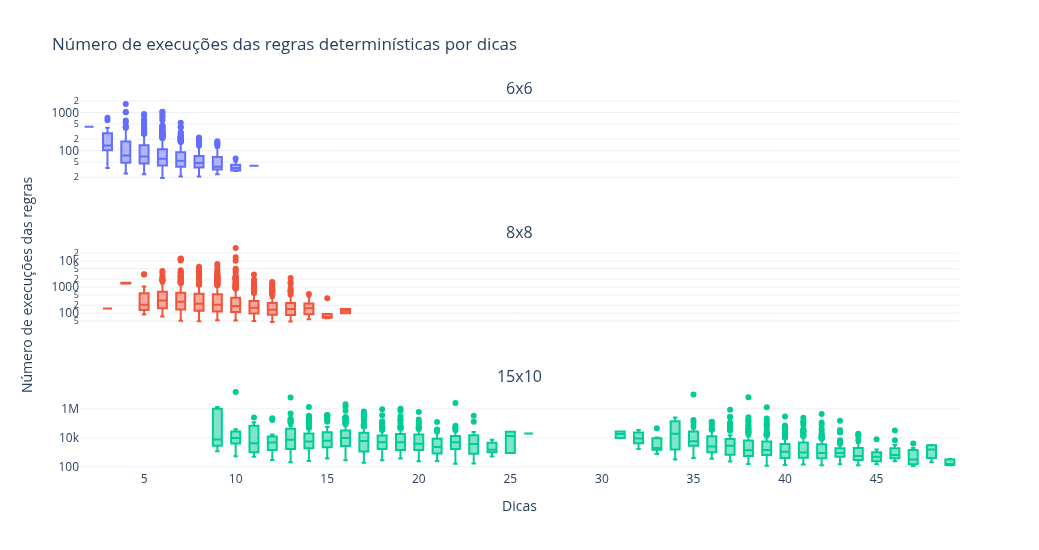

In [93]:
rows,cols=3,1
fig = make_subplots(rows=rows, cols=cols, subplot_titles=tabuleiros, shared_xaxes=True)

i,j=1,1
for tab in tabuleiros:
    r = results_regiao[results_regiao['tabuleiro'] == tab]
    # r = r[r['backtracks'] > 0]
    # for reg in regras:
        # if reg != "assign_from_singletons":
        #     continue
    b = go.Box(
        y=r[regras].sum(axis=1),
        x=r['dicas'],
        showlegend=False,
        # mode='markers'
    )
    fig.add_trace(b, row=i, col=j)
    j+=1
    if j > cols:
        j = 1
        i += 1
        
fig.update_yaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Número de execuções das regras determinísticas por dicas',
    xaxis3_title='Dicas',
    yaxis2_title='Número de execuções das regras',
    height=550
)


fig.show()

## Backtracks

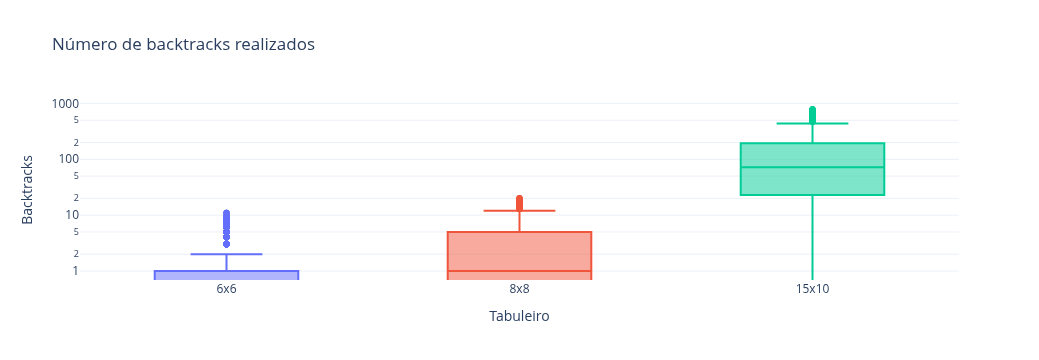

In [26]:
fig = go.Figure()

for tab in tabuleiros:
    r = results_regiao[results_regiao['tabuleiro'] == tab]
    #r = res[res['backtracks'] > 0]

    backtracks = remove_outliers(r['backtracks'], factor=1.5 if tab != '6x6' else 10)
    r = r[r['backtracks'].isin(backtracks.values)]
    
    b = go.Box(
        y=r['backtracks'],
        x=[tab for _ in r['backtracks']],
        showlegend=False,
    )
    fig.add_trace(b)
    


fig.update_yaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Número de backtracks realizados',
    xaxis_title='Tabuleiro',
    yaxis_title='Backtracks'
)


fig.show()

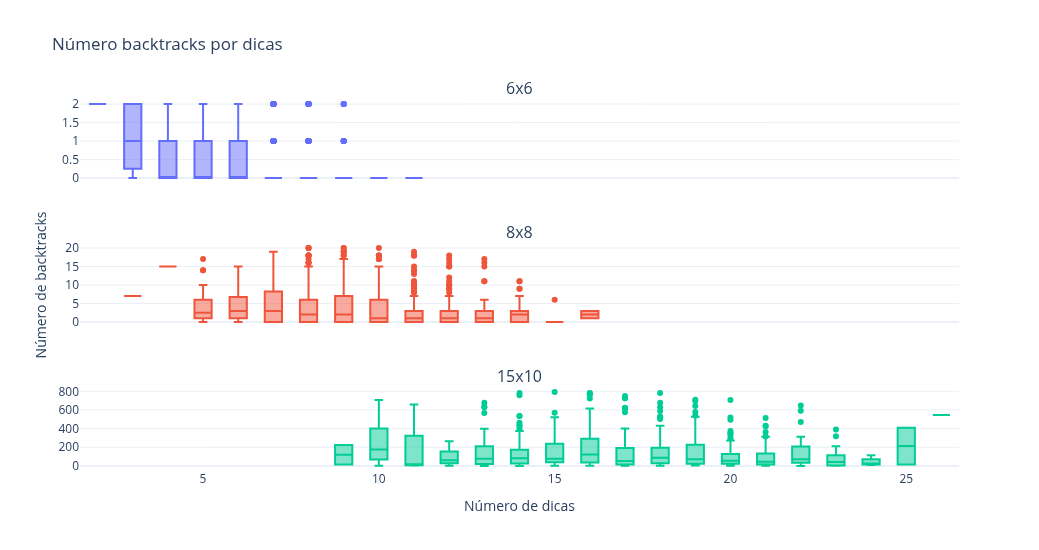

In [29]:
rows,cols=3,1
fig = make_subplots(rows=rows, cols=cols, subplot_titles=tabuleiros, shared_xaxes=True)

i,j=1,1
for tab in tabuleiros:
    r = results_regiao[results_regiao['tabuleiro'] == tab]
    backtracks = remove_outliers(r['backtracks'])
    r = r[r['backtracks'].isin(backtracks.values)]
    b = go.Box(
        y=r['backtracks'],
        x=r['dicas'],
        showlegend=False,
        # mode='markers'
    )
    fig.add_trace(b, row=i, col=j)
    j+=1
    if j > cols:
        j = 1
        i += 1
        
# fig.update_yaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Número backtracks por dicas',
    xaxis3_title='Número de dicas',
    yaxis2_title='Número de backtracks',
    height=550, width=750
)


fig.show()

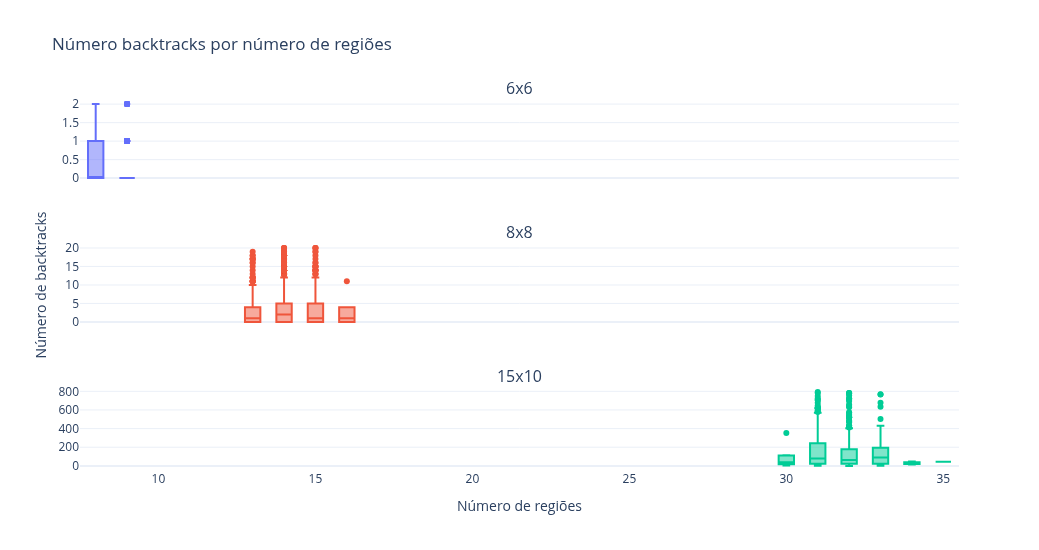

In [30]:
rows,cols=3,1
fig = make_subplots(rows=rows, cols=cols, subplot_titles=tabuleiros, shared_xaxes=True)

i,j=1,1
for tab in tabuleiros:
    r = results_regiao[results_regiao['tabuleiro'] == tab]
    backtracks = remove_outliers(r['backtracks'])
    r = r[r['backtracks'].isin(backtracks.values)]
    b = go.Box(
        y=r['backtracks'],
        x=r['numero_regioes'],
        showlegend=False,
        # mode='markers'
    )
    fig.add_trace(b, row=i, col=j)
    j+=1
    if j > cols:
        j = 1
        i += 1
        
# fig.update_yaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Número backtracks por número de regiões',
    xaxis3_title='Número de regiões',
    yaxis2_title='Número de backtracks',
    height=550, width=600
)


fig.show()

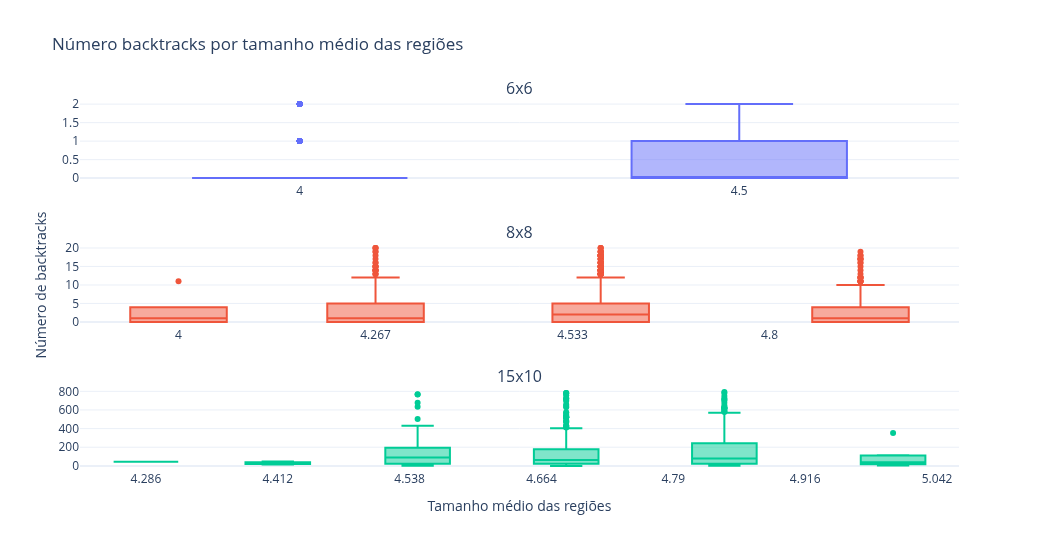

In [32]:
rows,cols=3,1
fig = make_subplots(rows=rows, cols=cols, subplot_titles=tabuleiros)

i,j=1,1
for tab in tabuleiros:
    r = results_regiao[results_regiao['tabuleiro'] == tab]
    backtracks = remove_outliers(r['backtracks'])
    r = r[r['backtracks'].isin(backtracks.values)]
    b = go.Box(
        y=r['backtracks'],
        x=r['tamanho_medio_regiao'],
        showlegend=False,
        # mode='markers'
    )
    fig.add_trace(b, row=i, col=j)
    j+=1
    if j > cols:
        j = 1
        i += 1
        
# fig.update_yaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Número backtracks por tamanho médio das regiões',
    xaxis3_title='Tamanho médio das regiões',
    yaxis2_title='Número de backtracks',
    height=550, width=600
)


fig.show()

## Tempo

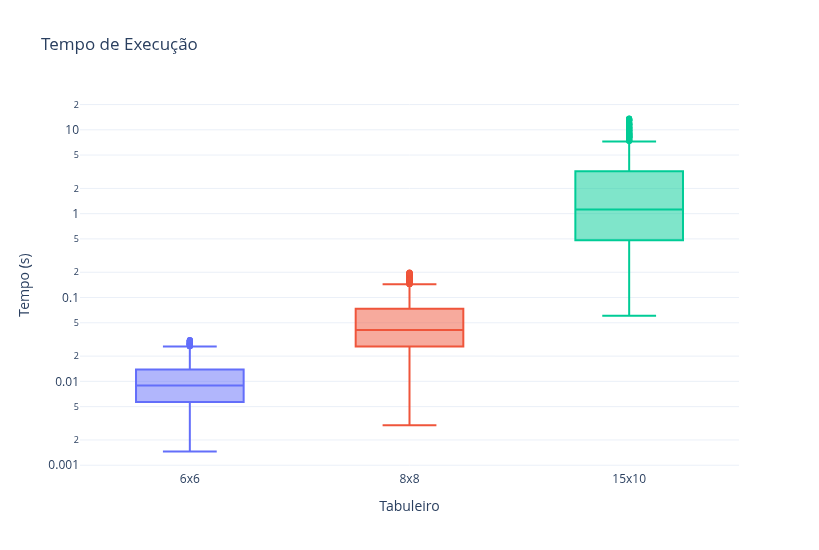

In [162]:
fig = go.Figure()
#fig = make_subplots(rows=3, cols=1, subplot_titles=tabuleiros)

i = 1
for tab in tabuleiros:
    res = results_regiao[results_regiao['tabuleiro'] == tab]

    res = res[res['tempo'].isin(remove_outliers(res['tempo']))]
    b = go.Box(
        y=res['tempo'],
        x=[tab for _ in res['tempo']],
        showlegend=False,
    )
    fig.add_trace(b)
    i+=1



fig.update_yaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Tempo de Execução',
    xaxis_title='Tabuleiro',
    yaxis_title='Tempo (s)',
    height=550, width=600
)


fig.show()

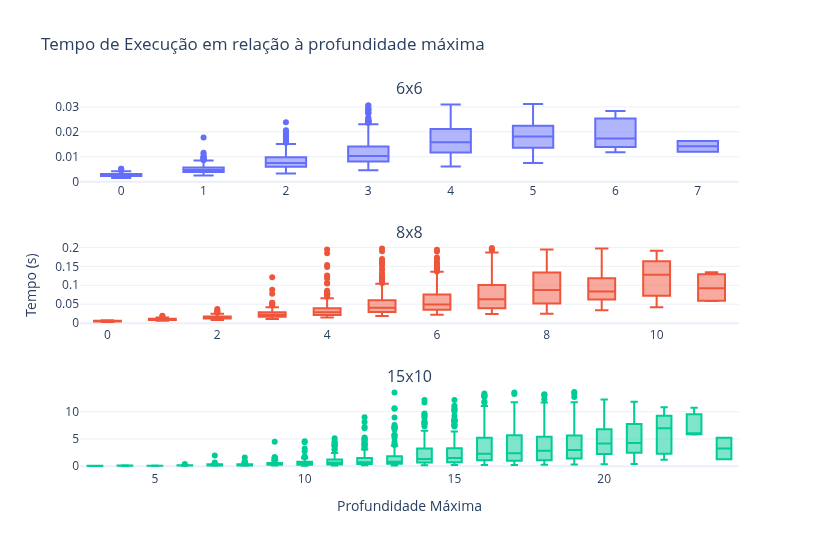

In [154]:
fig = go.Figure()
fig = make_subplots(rows=3, cols=1, subplot_titles=tabuleiros)

i = 1
for tab in tabuleiros:
    res = results_regiao[results_regiao['tabuleiro'] == tab]

    res = res[res['tempo'].isin(remove_outliers(res['tempo']))]
    b = go.Box(
        y=res['tempo'],
        x=res['profundidade_maxima'],
        showlegend=False,
    )
    fig.add_trace(b, row=i, col=1)
    i+=1



# fig.update_yaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Tempo de Execução em relação à profundidade máxima',
    xaxis3_title='Profundidade Máxima',
    yaxis2_title='Tempo (s)',
    height=550, width=600
)


fig.show()

In [185]:
model = sm.OLS(r['tempo'].values, (r['blanks']/r['size']).values).fit()
print(model.summary2())
model.params[0]

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.426    
Dependent Variable:     y                AIC:                         6750.0027
Date:                   2025-11-30 14:13 BIC:                         6755.2246
No. Observations:       1369             Log-Likelihood:              -3374.0  
Df Model:               1                F-statistic:                 1016.    
Df Residuals:           1368             Prob (F-statistic):          3.41e-167
R-squared (uncentered): 0.426            Scale:                       8.1011   
-------------------------------------------------------------------------------------
           Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
x1         3.0283         0.0950       31.8736       0.0000       2.8419       3.2147
----------------------------------------

np.float64(3.028315707055367)

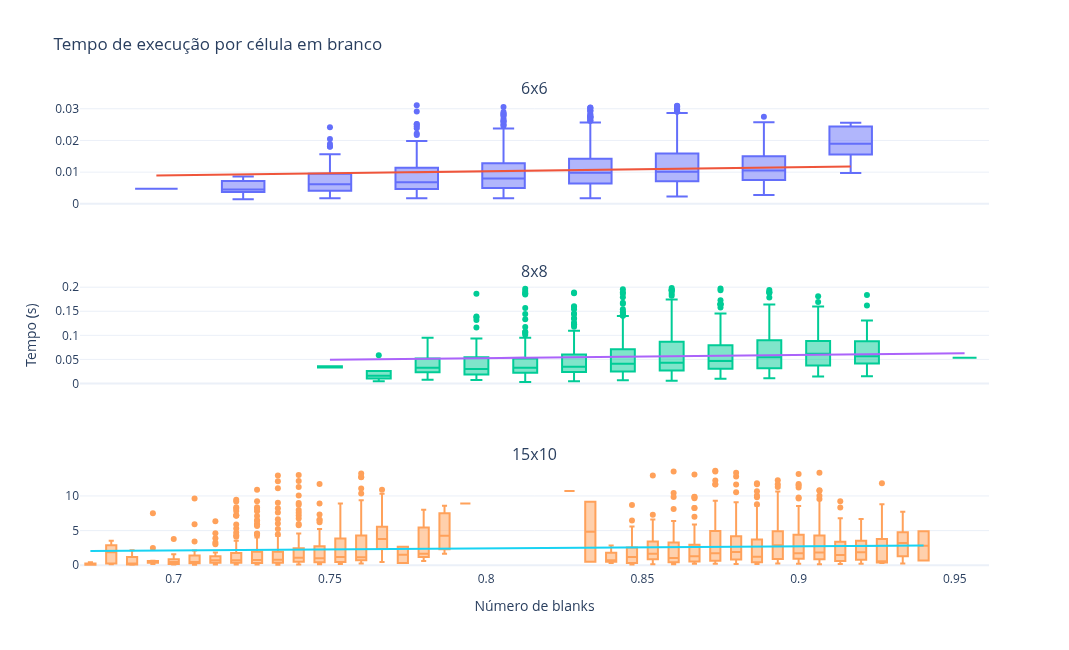

In [181]:
rows,cols=3,1
fig = make_subplots(rows=rows, cols=cols, subplot_titles=tabuleiros, shared_xaxes=True)

i,j=1,1
for tab in tabuleiros:
    r = results_regiao[results_regiao['tabuleiro'] == tab]
    backtracks = remove_outliers(r['tempo'])
    r = r[r['tempo'].isin(backtracks.values)]
    model = sm.OLS(r['tempo'].values, (r['blanks']/r['size']).values).fit()
    b = go.Box(
        y=r['tempo'],
        x=r['blanks']/r['size'],
        showlegend=False,
 
    )
    fig.add_trace(b, row=i, col=j)

    b = go.Scatter(
        y=r['blanks']/r['size'] * model.params[0],
        x=r['blanks']/r['size'],
        showlegend=False,
 
    )
    fig.add_trace(b, row=i, col=j)

    j+=1
    if j > cols:
        j = 1
        i += 1
        
# fig.update_yaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Tempo de execução por célula em branco',
    xaxis3_title='Número de blanks',
    yaxis2_title='Tempo (s)',
    height=650, width=650
)


fig.show()

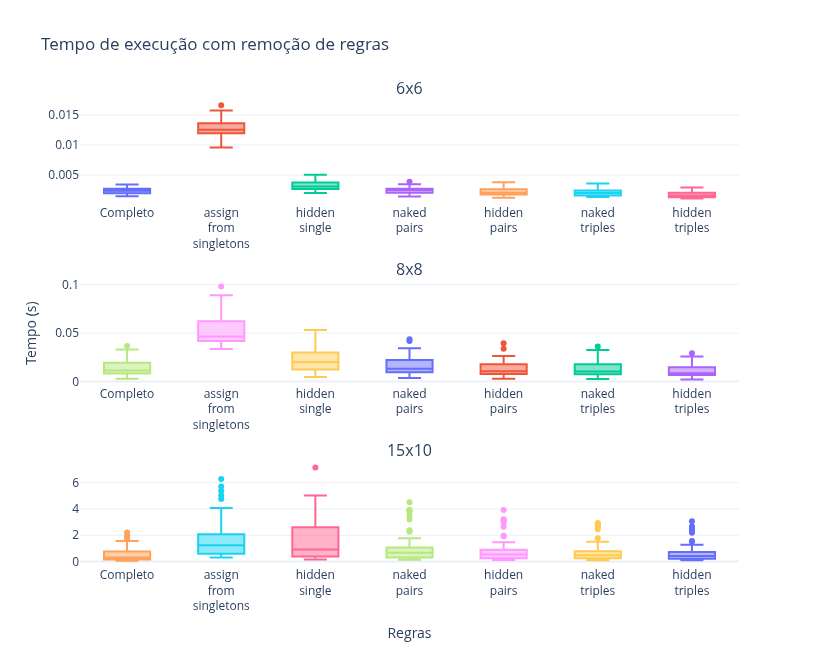

In [165]:
rows,cols=3,1
fig = make_subplots(rows=rows, cols=cols, subplot_titles=tabuleiros, shared_xaxes=False)

i,j=1,1
for tab in tabuleiros:
    r = results_regiao[results_regiao['tabuleiro'] == tab]
    r = r[r.index.isin(teste_podas[regra].index)]
    
    b = go.Box(
        y=remove_outliers(r['tempo']),
        x=['Completo' for _ in remove_outliers(r['tempo'])],
        showlegend=False,
    )
    fig.add_trace(b, row=i, col=j)
    
    for regra in teste_podas.keys():
        r = teste_podas[regra][teste_podas[regra]['tabuleiro'] == tab]
        b = go.Box(
            y=remove_outliers(r['tempo']),
            x=[regra.replace('_', '<br>') for _ in remove_outliers(r['tempo'])],
            showlegend=False,
        )
        fig.add_trace(b, row=i, col=j)
    j+=1
    if j > cols:
        j = 1
        i += 1
        
# fig.update_yaxes(type='log')
# fig.update_xaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Tempo de execução com remoção de regras',
    xaxis3_title='Regras',
    yaxis2_title='Tempo (s)',
    height=650
)


fig.show()

In [125]:
subplot_titles = []

for t in tabuleiros:
    for r in regras:
        if 'singleton' in r:
            r = 'singleton'
        s = f'{t}-{r}'
        subplot_titles.append(s)

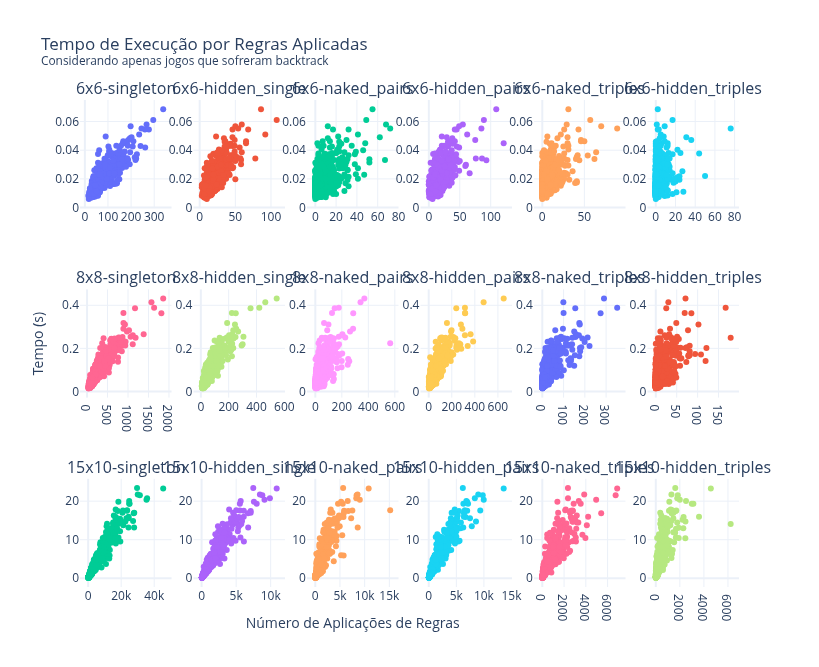

In [78]:
rows,cols=3,6
fig = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles, shared_xaxes=False)

i,j=1,1
for tab in tabuleiros:
    r = results_regiao[results_regiao['tabuleiro'] == tab]
    r = r[r['backtracks'] > 0]
    backtracks = remove_outliers(r['backtracks'])
    r = r[r['backtracks'].isin(backtracks.values)]

    for reg in regras:
        b = go.Scatter(
            y=r['tempo'],
            x=r[reg],
            showlegend=False,
            mode='markers'
     
        )
        fig.add_trace(b, row=i, col=j)
        j+=1
        if j > cols:
            j = 1
            i += 1
        
# fig.update_yaxes(type='log')
# fig.update_xaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Tempo de Execução por Regras Aplicadas<br><sup>Considerando apenas jogos que sofreram backtrack</sup>',
    xaxis15_title='Número de Aplicações de Regras',
    yaxis7_title='Tempo (s)',
    height=650, width=1200
)


fig.show()

In [82]:
def standard_scale(df):
    df = df.copy()
    for col in df.columns:
        mean = df[col].mean()
        std = df[col].std()
        # evita divisão por zero
        if std == 0 or np.isnan(std):
            df[col] = 0
        else:
            df[col] = (df[col] - mean) / std
    return df

In [94]:
model.pvalues

assign_from_singletons    8.055125e-23
hidden_single             1.328934e-04
naked_pairs               5.841607e-06
hidden_pairs              2.706558e-05
naked_triples             1.699682e-04
hidden_triples            1.177847e-03
backtracks                2.056144e-76
dtype: float64

In [105]:
coefs = pd.DataFrame(columns=['tabuleiro', 'coeficiente', 'valor', 'p-valor'])

for tab in tabuleiros:
    coefs_tab = pd.DataFrame(columns=['tabuleiro', 'valor', 'p-valor'])
    r = results_regiao[results_regiao['tabuleiro'] == tab]
    r = r[r['backtracks'] > 0]
    backtracks = remove_outliers(r['backtracks'])
    r = r[r['backtracks'].isin(backtracks.values)]
    r = r.drop(columns=['id', 'tabuleiro', 'resolvido'])
    r = standard_scale(r)

    Xset = regras+['backtracks']
    X = r[Xset]
    y = r['tempo']
    model = sm.OLS(y,X).fit()
    coefs_tab['valor'] = model.params
    coefs_tab['p-valor'] = model.pvalues
    coefs_tab['tabuleiro'] = tab
    coefs_tab = coefs_tab.reset_index().rename(columns={'index':'coeficiente'}).sort_values(by=['valor'], ascending=False)
    coefs = pd.concat([coefs, coefs_tab])
coefs.to_csv('time_coef.csv')

/tmp/ipykernel_53727/947698851.py:20: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



# Comparando com Célula

In [166]:
for id in results_regiao.index:
    try:
        rr = results_regiao.loc[id]
        rc = results_celula.loc[id]
    except:
        continue
    if rr['backtracks'] != rc['backtracks']:
        if rr['backtracks'] == 0:
            results_celula.loc[id, 'backtracks'] = 0
        elif rc['backtracks'] == 0:
            results_regiao.loc[id, 'backtracks'] = 0
            

In [167]:
df = results_celula.join(results_regiao, lsuffix='_cell', rsuffix='_region', how='inner')
df = df[(df['backtracks_cell'] > 0) & (df['backtracks_region'] > 0)]

In [168]:
model = sm.OLS(np.log(r['tempo_region']), np.log(r['tempo_cell'])).fit()
print(model.summary2())

KeyError: 'tempo_region'

In [111]:
f = lambda tempo_cell: float(model.params['tempo_cell'])*tempo_cell

In [112]:
rows,cols=3,1
fig = go.Figure()


r = df
print(
    pd.DataFrame({
        'r':np.log(r['tempo_region']),
        'c':np.log(r['tempo_cell']),
    }).corr()
)
b = go.Scatter(
    y=r['tempo_region'],
    x=r['tempo_cell'],
    showlegend=False,
    mode='markers'
)
fig.add_trace(b)

b = go.Scatter(
    y=f(r['tempo_cell']),
    x=r['tempo_cell'],
    showlegend=False,
    mode='markers'
)
fig.add_trace(b)

fig.update_yaxes(type='log')
fig.update_xaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Tempo de Execução<br><sup>Comparando backtracking por célula e por região</sup>',
    xaxis_title='Tempo (célula)',
    yaxis_title='Tempo (região)',
    height=500, width=550
)


fig.show()

          r         c
r  1.000000  0.823851
c  0.823851  1.000000


KeyError: 'tempo_cell'

In [45]:
df

id_cell tabuleiro_cell  size_cell  \
6x6_Suguru-36          Suguru-36            6x6         36   
6x6_Suguru-935        Suguru-935            6x6         36   
6x6_Suguru-992        Suguru-992            6x6         36   
6x6_Suguru-1278      Suguru-1278            6x6         36   
6x6_Suguru-1503      Suguru-1503            6x6         36   
...                          ...            ...        ...   
15x10n=6_Suguru-172   Suguru-172          15x10        150   
15x10n=6_Suguru-348   Suguru-348          15x10        150   
15x10n=6_Suguru-371   Suguru-371          15x10        150   
15x10n=6_Suguru-386   Suguru-386          15x10        150   
15x10n=6_Suguru-400   Suguru-400          15x10        150   

                     numero_regioes_cell  tamanho_medio_regiao_cell  \
6x6_Suguru-36                          8                   4.500000   
6x6_Suguru-935                         8                   4.500000   
6x6_Suguru-992                         8                   4.500000   
6x6_Suguru-1278                        8                   4.500000   
6x6_Suguru-1503                        8                   4.500000   
...                                  ...                        ...   
15x10n=6_Suguru-172                   25                   6.000000   
15x10n=6_Suguru-348                   26                   5.769231   
15x10n=6_Suguru-371                   27                   5.555556   
15x10n=6_Suguru-386                   25                   6.000000   
15x10n=6_Suguru-400                   26                   5.769231   

                     dificuldade_cell  dicas_cell  tempo_cell  \
6x6_Suguru-36                       2           9    0.041988   
6x6_Suguru-935                      2           7    0.024261   
6x6_Suguru-992                      3           7    0.008706   
6x6_Suguru-1278                     2           9    0.009269   
6x6_Suguru-1503                     2           7    0.009169   
...                               ...         ...         ...   
15x10n=6_Suguru-172                 3          42  136.292703   
15x10n=6_Suguru-348                 3          42    0.410278   
15x10n=6_Suguru-371                 3          40    0.266003   
15x10n=6_Suguru-386                 3          45    3.897036   
15x10n=6_Suguru-400                 3          40    1.868893   

                     nos_visitados_cell  profundidade_maxima_cell  ...  \
6x6_Suguru-36                        64                         6  ...   
6x6_Suguru-935                       50                         6  ...   
6x6_Suguru-992                       41                         3  ...   
6x6_Suguru-1278                      39                         2  ...   
6x6_Suguru-1503                      40                         2  ...   
...                                 ...                       ...  ...   
15x10n=6_Suguru-172               12518                        35  ...   
15x10n=6_Suguru-348                 190                        19  ...   
15x10n=6_Suguru-371                 180                        18  ...   
15x10n=6_Suguru-386                 491                        19  ...   
15x10n=6_Suguru-400                 301                        23  ...   

                     profundidade_maxima_region  total_podas_region  \
6x6_Suguru-36                                 4                  75   
6x6_Suguru-935                                4                 229   
6x6_Suguru-992                                3                  49   
6x6_Suguru-1278                               2                  32   
6x6_Suguru-1503                               3                 217   
...                                         ...                 ...   
15x10n=6_Suguru-172                          19              432824   
15x10n=6_Suguru-348                          16                7722   
15x10n=6_Suguru-371                          16                2535   
15x10n=6_Suguru-386                          14

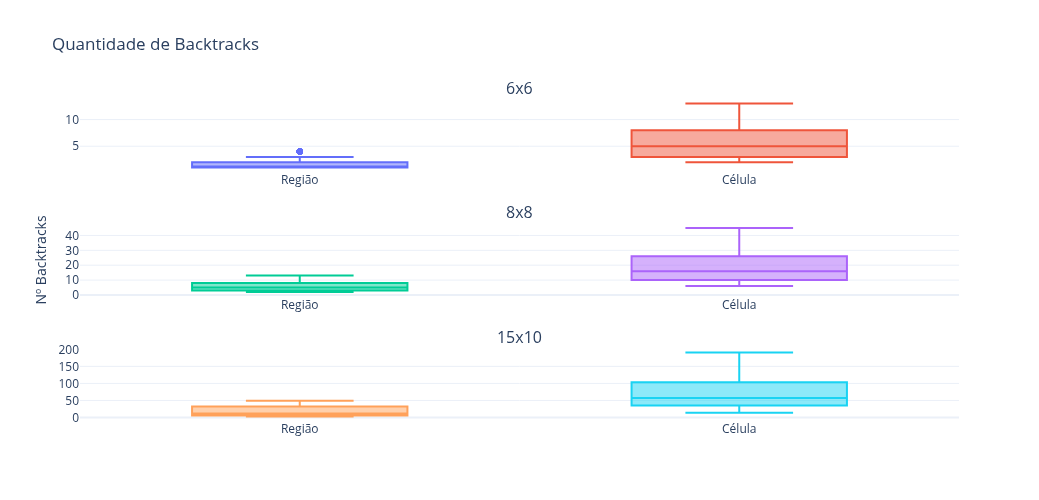

In [44]:
rows, cols= 3,1
fig = make_subplots(rows=rows, cols=cols, subplot_titles=tabuleiros)

i,j=1,1
for tab in tabuleiros:
    r = df[df['tabuleiro_cell'] == tab]
    br = remove_outliers(r['backtracks_region'], 0)
    bc = remove_outliers(r['backtracks_cell'], 0)
    b = go.Box(
        y=br,
        x=['Região' for _ in br],
        showlegend=False,
    )
    fig.add_trace(b, row=i, col=j)
    b = go.Box(
        y=bc,
        x=['Célula' for _ in bc],
        showlegend=False,
    )
    fig.add_trace(b, row=i, col=j)
    j+=1
    if j > cols:
        j=1;i+=1
    

# fig.update_yaxes(type='log')
# fig.update_xaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Quantidade de Backtracks',
    # xaxis3_title='Nº Backtracks (célula)',
    yaxis2_title='Nº Backtracks',
    height=500, width=550
)


fig.show()

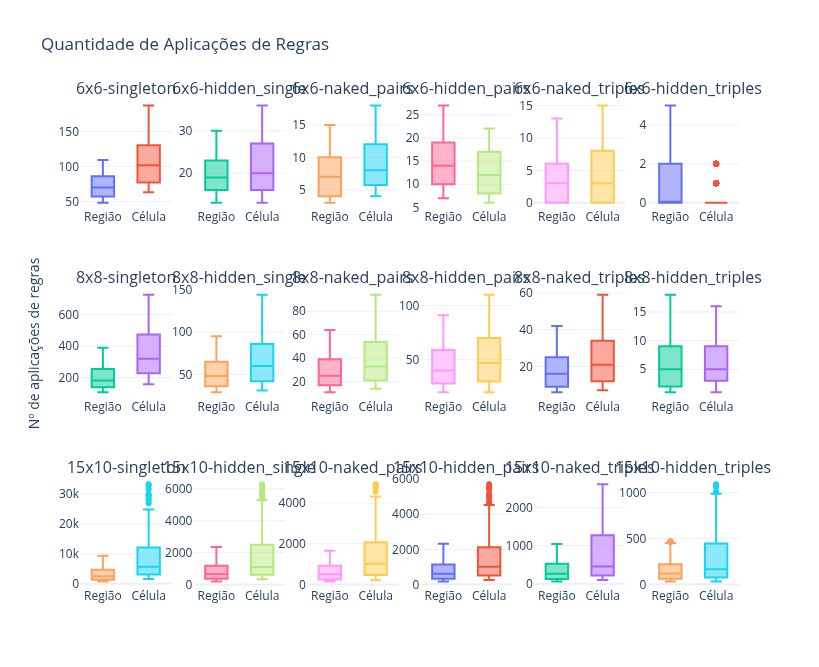

In [127]:
rows, cols= 3,6
fig = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles)

i,j=1,1
for tab in tabuleiros:
    r = df[df['tabuleiro_cell'] == tab]

    for reg in regras:
        br = remove_outliers(r[f'{reg}_region'], 0)
        bc = remove_outliers(r[f'{reg}_cell'], 0)
        b = go.Box(
            y=br,
            x=['Região' for _ in br],
            showlegend=False,
        )
        fig.add_trace(b, row=i, col=j)
        b = go.Box(
            y=bc,
            x=['Célula' for _ in bc],
            showlegend=False,
        )
        fig.add_trace(b, row=i, col=j)
        j+=1
        if j > cols:
            j=1;i+=1
        

# fig.update_yaxes(type='log')
# fig.update_xaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Quantidade de Aplicações de Regras',
    # xaxis3_title='Nº Backtracks (célula)',
    yaxis7_title='Nº de aplicações de regras',
    height=650, width=1250
)


fig.show()

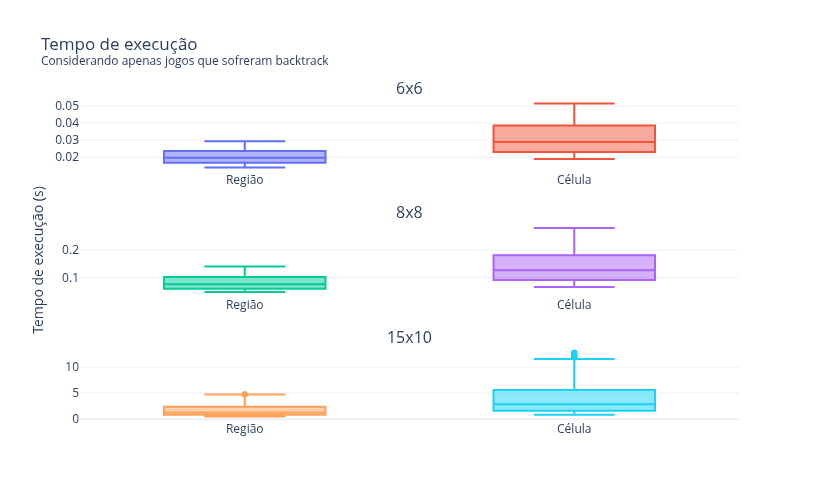

In [169]:
rows, cols= 3,1
fig = make_subplots(rows=rows, cols=cols, subplot_titles=tabuleiros)

i,j=1,1
for tab in tabuleiros:
    r = df[df['tabuleiro_cell'] == tab]
    br = remove_outliers(r['tempo_region'], 0)
    bc = remove_outliers(r['tempo_cell'], 0)
    b = go.Box(
        y=br,
        x=['Região' for _ in br],
        showlegend=False,
    )
    fig.add_trace(b, row=i, col=j)
    b = go.Box(
        y=bc,
        x=['Célula' for _ in bc],
        showlegend=False,
    )
    fig.add_trace(b, row=i, col=j)
    j+=1
    if j > cols:
        j=1;i+=1
    

# fig.update_yaxes(type='log')
# fig.update_xaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Tempo de execução<br><sup>Considerando apenas jogos que sofreram backtrack</sup>',
    # xaxis3_title='Nº Backtracks (célula)',
    yaxis2_title='Tempo de execução (s)',
    height=500, width=550
)


fig.show()

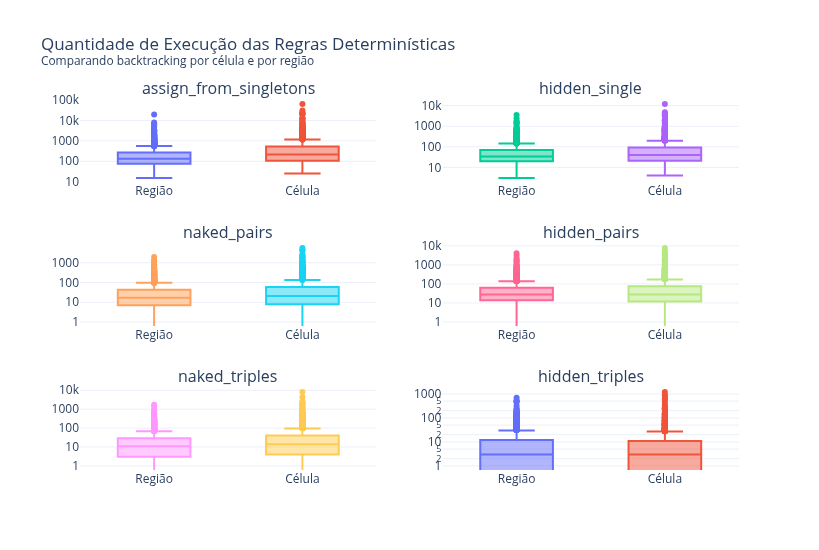

In [219]:
rows,cols = 3,2
fig = make_subplots(rows=rows, cols=cols, subplot_titles=regras)

r = df
i,j=1,1
for regra in regras:
    b = go.Box(
        y=r[f'{regra}_region'],
        x=['Região' for _ in r[f'{regra}_region']],
        showlegend=False,
    )
    fig.add_trace(b, row=i,col=j)
    b = go.Box(
        y=r[f'{regra}_cell'],
        x=['Célula' for _ in r[f'{regra}_cell']],
        showlegend=False,
    )
    fig.add_trace(b, row=i,col=j)
    j+=1
    if j > cols:
        j = 1; i+=1

fig.update_yaxes(type='log')
# fig.update_xaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Quantidade de Execução das Regras Determinísticas<br><sup>Comparando backtracking por célula e por região</sup>',
    height=550, width=750
)


fig.show()

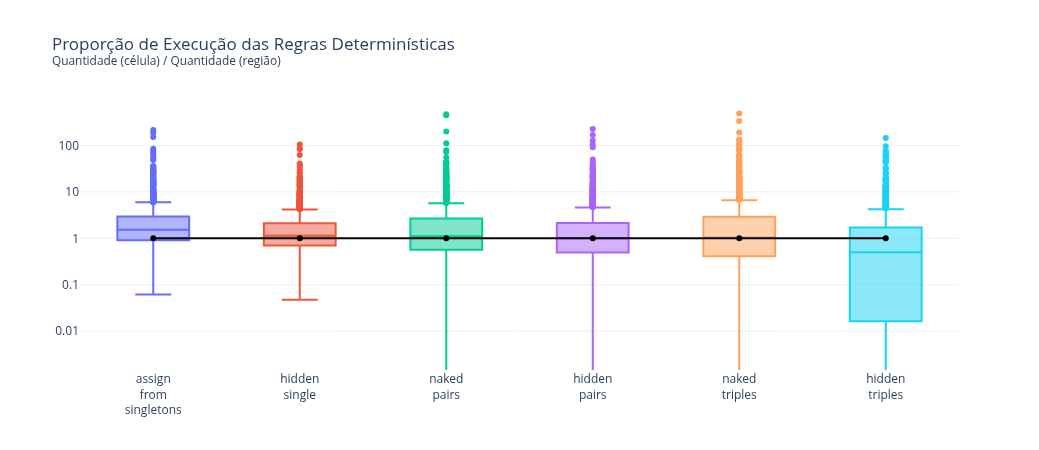

In [238]:

fig = go.Figure()

r = df
for regra in regras:
    diff = r[f'{regra}_cell'] / r[f'{regra}_region']
    b = go.Box(
        y=diff,
        x=[regra.replace('_', '<br>') for _ in r[f'{regra}_region']],
        showlegend=False,
    )
    fig.add_trace(b)

b = go.Scatter(
    y=[1 for _ in regras],
    x=[r.replace('_', '<br>') for r in regras],
    showlegend=False,
    marker_color='black'
)
fig.add_trace(b)

fig.update_yaxes(type='log')
# fig.update_xaxes(type='log')
fig.update_layout(
    template='plotly_white',
    title='Proporção de Execução das Regras Determinísticas<br><sup>Quantidade (célula) / Quantidade (região)</sup>',
    height=450, width=750
)


fig.show()